In [1]:
pip install pandas matplotlib statsmodels


Adj Close is non-stationary. Applying first differencing.
SP_Ajclose is non-stationary. Applying first differencing.
DJ_Ajclose is non-stationary. Applying first differencing.
EU_Price is non-stationary. Applying first differencing.
OF_Price is non-stationary. Applying first differencing.
OS_Price is non-stationary. Applying first differencing.
SF_Price is non-stationary. Applying first differencing.
USB_Price is non-stationary. Applying first differencing.


C:\Users\jaya karthick\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 12, Apr, 2025
Time:                     12:14:03
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.12544
Nobs:                     1706.00    HQIC:                   3.98078
Log likelihood:          -22616.8    FPE:                    49.1941
AIC:                      3.89577    Det(Omega_mle):         47.1663
--------------------------------------------------------------------
Results for equation Adj Close
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.027151         0.030373           -0.894           0.371
L1.Adj Close         -0.016580         0.035693           -0.465           0.642
L1.SP_Ajclose         0.109411         0.070253         

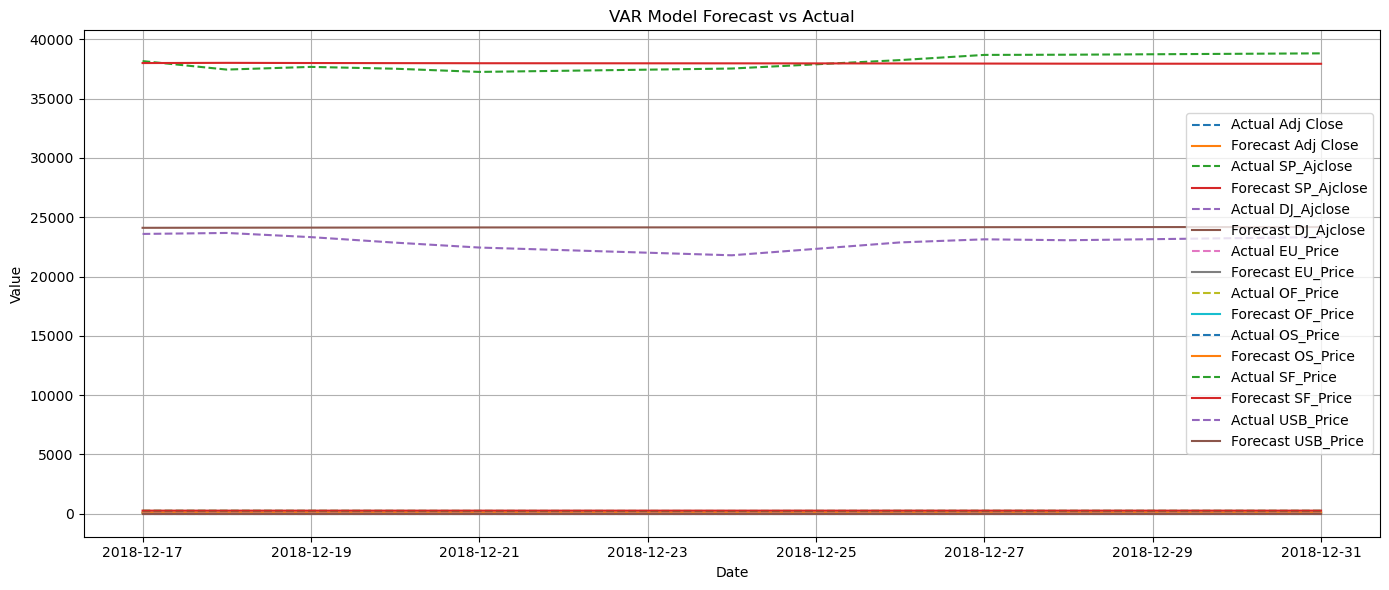

In [1]:
# === 1. Import Required Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# === 2. Load Multivariate Time Series Data ===
file_path = r"D:/221501507/TIME SERIES ANALYSIS AND FORECASTING/EX06/archive (1) (1)/FINAL_USO.csv"  # ✅ Replace with your multivariate data path
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
df.columns = df.columns.str.strip()

# ✅ Example: Only select relevant numeric columns for modeling
features = ['Adj Close', 'SP_Ajclose', 'DJ_Ajclose', 'EU_Price', 'OF_Price', 'OS_Price', 'SF_Price', 'USB_Price']
data = df[features].dropna()

# === 3. Check for Stationarity & Apply Differencing ===
def make_stationary(df):
    df_diff = df.copy()
    for col in df.columns:
        result = adfuller(df[col])
        if result[1] > 0.05:
            print(f"{col} is non-stationary. Applying first differencing.")
            df_diff[col] = df[col].diff().dropna()
    return df_diff.dropna()

stationary_data = make_stationary(data)

# === 4. Split into Train-Test ===
n_obs = 10  # Days to forecast
train = stationary_data[:-n_obs]
test = stationary_data[-n_obs:]

# === 5. Fit VAR Model ===
model = VAR(train)
lag_order = model.select_order(maxlags=15)
selected_lag = lag_order.aic  # you can use 'bic', 'fpe', etc.

model_fitted = model.fit(selected_lag)
print(model_fitted.summary())

# === 6. Forecast ===
forecast_input = train.values[-selected_lag:]
forecast_result = model_fitted.forecast(y=forecast_input, steps=n_obs)

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast_result, index=test.index, columns=train.columns)

# === 7. Invert Differencing to Get Actual Predictions ===
last_obs = data.iloc[-n_obs - 1]
reconstructed = forecast_df.cumsum() + last_obs
reconstructed.index = test.index

# === 8. Plot Forecast vs Actual ===
plt.figure(figsize=(14, 6))
for col in train.columns:
    plt.plot(data[col].iloc[-n_obs:], label=f'Actual {col}', linestyle='--')
    plt.plot(reconstructed[col], label=f'Forecast {col}')
plt.title("VAR Model Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
